<a href="https://colab.research.google.com/github/victor-bastos/DataScienceIntroduction/blob/main/LAB2/Lab2_CMC_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CMC-13 Lab. 2: Aprendizado de Máquina Não Supervisionado
## Victor Hugo de Oliveira Bastos

# Table of Content

* [Preparação dos dados](#prep)
  * [Importação de pacotes e carregamento dos dados](#imp)
  * [Primeira análise](#ana)
    * [Excluindo features não desejadas](#exc)
  * [Preenchendo valores nulos](#nulo)
* [Análise exploratória](#anexp)
  * [Lidando com outliers](#out)
  * [Categorical encoding](#cat)
  * [Discretização de variáveis](#disc)
  *[Escala de variáveis](#scal)
  *[Transformação de variáveis](#transf)
* [Aplicando o modelo K-Means](#KNN)
  * [Testes 'manuais' e visualização](#manu)
    * [Elbow curve](#elbow)
    * [Plot dos clusters usando PCA](#PCA)
* [Conclusão](#conclusao)


<a name='prep'></a>
# 1 - Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [ ]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use('ggplot')

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Mounted at /content/drive


In [ ]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 7.5 MB/s eta 0:00:00


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [ ]:
# Carregando os dados...

# Definindo o caminho onde os arquivos estão armazenados
path_files = '/content/drive/MyDrive/Colab Notebooks/Lab1_CMC-13/'

# URL do arquivo CSV
url_data = 'https://drive.google.com/file/d/1imvjoPjyoBIkaywjwva_BANlwM7WBZpR/view?usp=sharing'

# Extração do identificador do arquivo da URL
file_id = url_data.split('/')[-2]

# Construção do link de download direto do arquivo
url_download = 'https://drive.google.com/uc?id=' + file_id

# Leitura do arquivo CSV e criação do DataFrame
df = pd.read_csv(url_download, on_bad_lines='skip', sep=',')


<a name='ana'></a>
## Primeira análise

Primeiramente, analisa-se o aspecto geral do *dataset*, visualizando todas as colunas e os tipos de dados presentes.

In [ ]:
df.head()

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
0,0,8.078,6.68,7.201,4.88,4.181,3.70,5.50,4.03,3.870,3.84
1,1,8.891,6.63,8.053,5.59,4.704,4.30,80.22,4.51,4.150,4.01
2,2,7.997,6.37,6.926,5.28,4.307,3.90,75.35,4.04,3.831,3.34
3,3,7.765,5.70,6.576,4.77,4.004,3.52,69.17,3.40,3.578,3.41
4,4,6.280,4.84,5.209,3.73,3.395,2.72,56.27,2.96,3.188,3.13


A fim de visualizar o quão repetitivo são os dados, analisa-se a quantidade de valores únicos por coluna.

In [ ]:
df.nunique()

id       420
huml     407
humw     321
ulnal    398
ulnaw    308
feml     402
femw     290
tibl     405
tibw     288
tarl     409
tarw     279
dtype: int64

Com base nesse resultado, nota-se que a coluna "id" não traz informação relevante a respeito da classificação das aves. As demais colunas são numéricas e contínuas, portanto, podem ser utilizadas no algoritmo de classificação.







<a name='exc'></a>
### Excluindo features não desejadas

Assim, exclui-se do *dataframe* a coluna de "id". Para que tal informação não seja perdida, opta-se por armazenar seu conteúdo numa variável.

In [ ]:
# Obtendo a coluna 'id' e armazenando em uma variável separada
id = df['id']

# Removendo a coluna 'id' do DataFrame
df.drop(columns=['id'], inplace=True)


Após a remoção da coluna indesejada, é necessário analisar a quantidade de valores faltantes no *dataset*, para obter um conjunto de dados consolidado.

In [ ]:
# Verificando a quantidade de valores ausentes em cada coluna do DataFrame
df.isna().sum()

huml     1
humw     1
ulnal    3
ulnaw    2
feml     2
femw     1
tibl     2
tibw     1
tarl     1
tarw     1
dtype: int64

O número de valores faltantes é baixo para cada coluna: a maior quantidade é '3' para "*ulnal*" (ulna). Portanto, é importante visualizar as linhas que possuem valores faltantes para determinar se é preferível excluir ou tratar tais dados.

In [ ]:
# Selecionando as linhas do DataFrame onde a coluna 'ulnal' possui valores ausentes
df[df['ulnal'].isna()]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
204,6.376,4.74,NaN,NaN,5.733,4.88,75.67,4.33,6.019,3.82
342,NaN,NaN,NaN,NaN,3.254,2.65,55.06,2.81,3.894,2.25
378,2.010,1.86,NaN,1.52,1.721,1.22,NaN,NaN,1.846,0.91


Da exibição das 3 linhas, constata-se que a linha 342 possui vários valores faltantes, enquanto as linhas 204 e 378 poderiam ser tratadas. Então, opta-se por excluir a linha 342.

In [ ]:
# Removendo a linha do DataFrame com o índice 342
df.drop(index=342, inplace=True)


<a name='nulo'></a>
## Preenchendo valores nulos

Após a exclusão da linha 342, visualiza-se novamente a quantidade de valores ausentes.

In [ ]:
# Verificando a quantidade de valores ausentes em cada coluna do DataFrame após a remoção da linha
df.isna().sum()

huml     0
humw     0
ulnal    2
ulnaw    1
feml     2
femw     1
tibl     2
tibw     1
tarl     1
tarw     1
dtype: int64

Como restaram pouquíssimos valores faltantes, então, pode-se preencher 'virtualmente' com baixo risco de *overfitting*. O procedimento para preencher os dados de comprimento e de largura é utilizar a média do valor correspondente às 5 aves mais similares à ave em análise.

Para iniciar, converte-se a coluna 'tibl' (Tibiotarso) para a mesma unidade de medida das outras. Após isso, obtém-se um resumo das estatísticas do *dataframe*.


In [ ]:
# Convertendo a coluna 'tibl' para centímetros
df['tibl'] = df['tibl'] / 10

# Obtendo estatísticas descritivas do DataFrame
df.describe()

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
count,419.000000,419.000000,417.000000,418.000000,417.000000,418.000000,417.000000,418.000000,418.000000,418.000000
mean,6.465050,4.370573,6.911537,3.597249,3.688281,3.222249,6.468585,3.183230,3.923067,2.931651
std,5.383455,2.854617,5.878477,2.186747,2.000195,2.025813,3.788066,2.083241,2.321209,2.188038
min,0.985000,1.140000,1.409000,1.000000,1.183000,0.930000,0.550000,0.870000,0.777000,0.660000
25%,2.517000,2.190000,2.805000,1.870000,2.128000,1.712500,3.639000,1.562500,2.302750,1.422500
50%,4.418000,3.500000,4.371000,2.945000,3.109000,2.515000,5.200000,2.490000,3.168500,2.225000
75%,9.031000,5.810000,9.752000,4.770000,4.713000,4.147500,8.287000,4.257500,5.034500,3.510000
max,42.000000,17.840000,42.200000,12.000000,11.707000,11.640000,24.000000,11.030000,17.500000,14.090000


A partir do resumo estatístico, é possível considerar que há uma concentração maior de aves de pequeno porte, pois os valores máximos estão distantes dos respectivos valores nos 3º quartis.

Para organizar a análise de largura e de comprimento, separa-se tais dados em duas variáveis.

In [ ]:
# Identificando quais colunas são comprimento e quais são largura

# Criando listas vazias para armazenar as colunas de comprimento e largura
largura = []
comprimento = []

# Percorrendo todas as colunas do DataFrame
for col in df.columns:
    # Verificando se o último caractere do nome da coluna é 'l' (indicando comprimento)
    if col[-1] == 'l':
        # Adicionando a coluna à lista de comprimento
        comprimento.append(col)
    else:
        # Caso contrário, adicionando a coluna à lista de largura
        largura.append(col)

# Exibindo a lista de colunas de comprimento para validar o resultado
comprimento

['huml', 'ulnal', 'feml', 'tibl', 'tarl']

Por fim, para preencher os valores faltantes, utiliza-se o método KNN para 5 vizinhos dentro do wrapper "*SklearnTransformerWrapper*". Essa prática traz vantagens, pois permite que o KNN seja aplicado dentro de um pipeline de transformações, especificando o estimador (*transformer*) e a variável (*variables*) a ser alterada.

In [ ]:
# Imputação multivariada
from sklearn.impute import KNNImputer
from feature_engine.wrappers import SklearnTransformerWrapper

# Iniciando o KNNImputer dentro do SklearnTransformerWrapper
for variavel in [comprimento, largura]:
    imputer = SklearnTransformerWrapper(
        transformer=KNNImputer(weights='distance', n_neighbors=5),
        variables=variavel
    )

    # Ajustando o imputer aos dados
    imputer.fit(df)

    # Aplicando a imputação aos dados
    df = imputer.transform(df)

# Verificando a quantidade de valores ausentes em cada coluna do DataFrame após a imputação
df.isna().sum()

huml     0
humw     0
ulnal    0
ulnaw    0
feml     0
femw     0
tibl     0
tibw     0
tarl     0
tarw     0
dtype: int64

<a name='anexp'></a>
#2 - Análise exploratória

A fim de iniciar a análise exploratória, é necessário visualizar a distribuição dos dados por meio de gráficos. Para isso, contrói-se funções que facilitem essas visualizações dado um *dataframe*.

In [ ]:
# Function to create a histogram, a Q-Q plot and
# a boxplot.

def diagnostic_plots(df, variable):

    # Define figure size.
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title(f'Histogram {variable}')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f'Probabilit Plot {variable}')
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(f'Boxplot {variable}')

    plt.show()


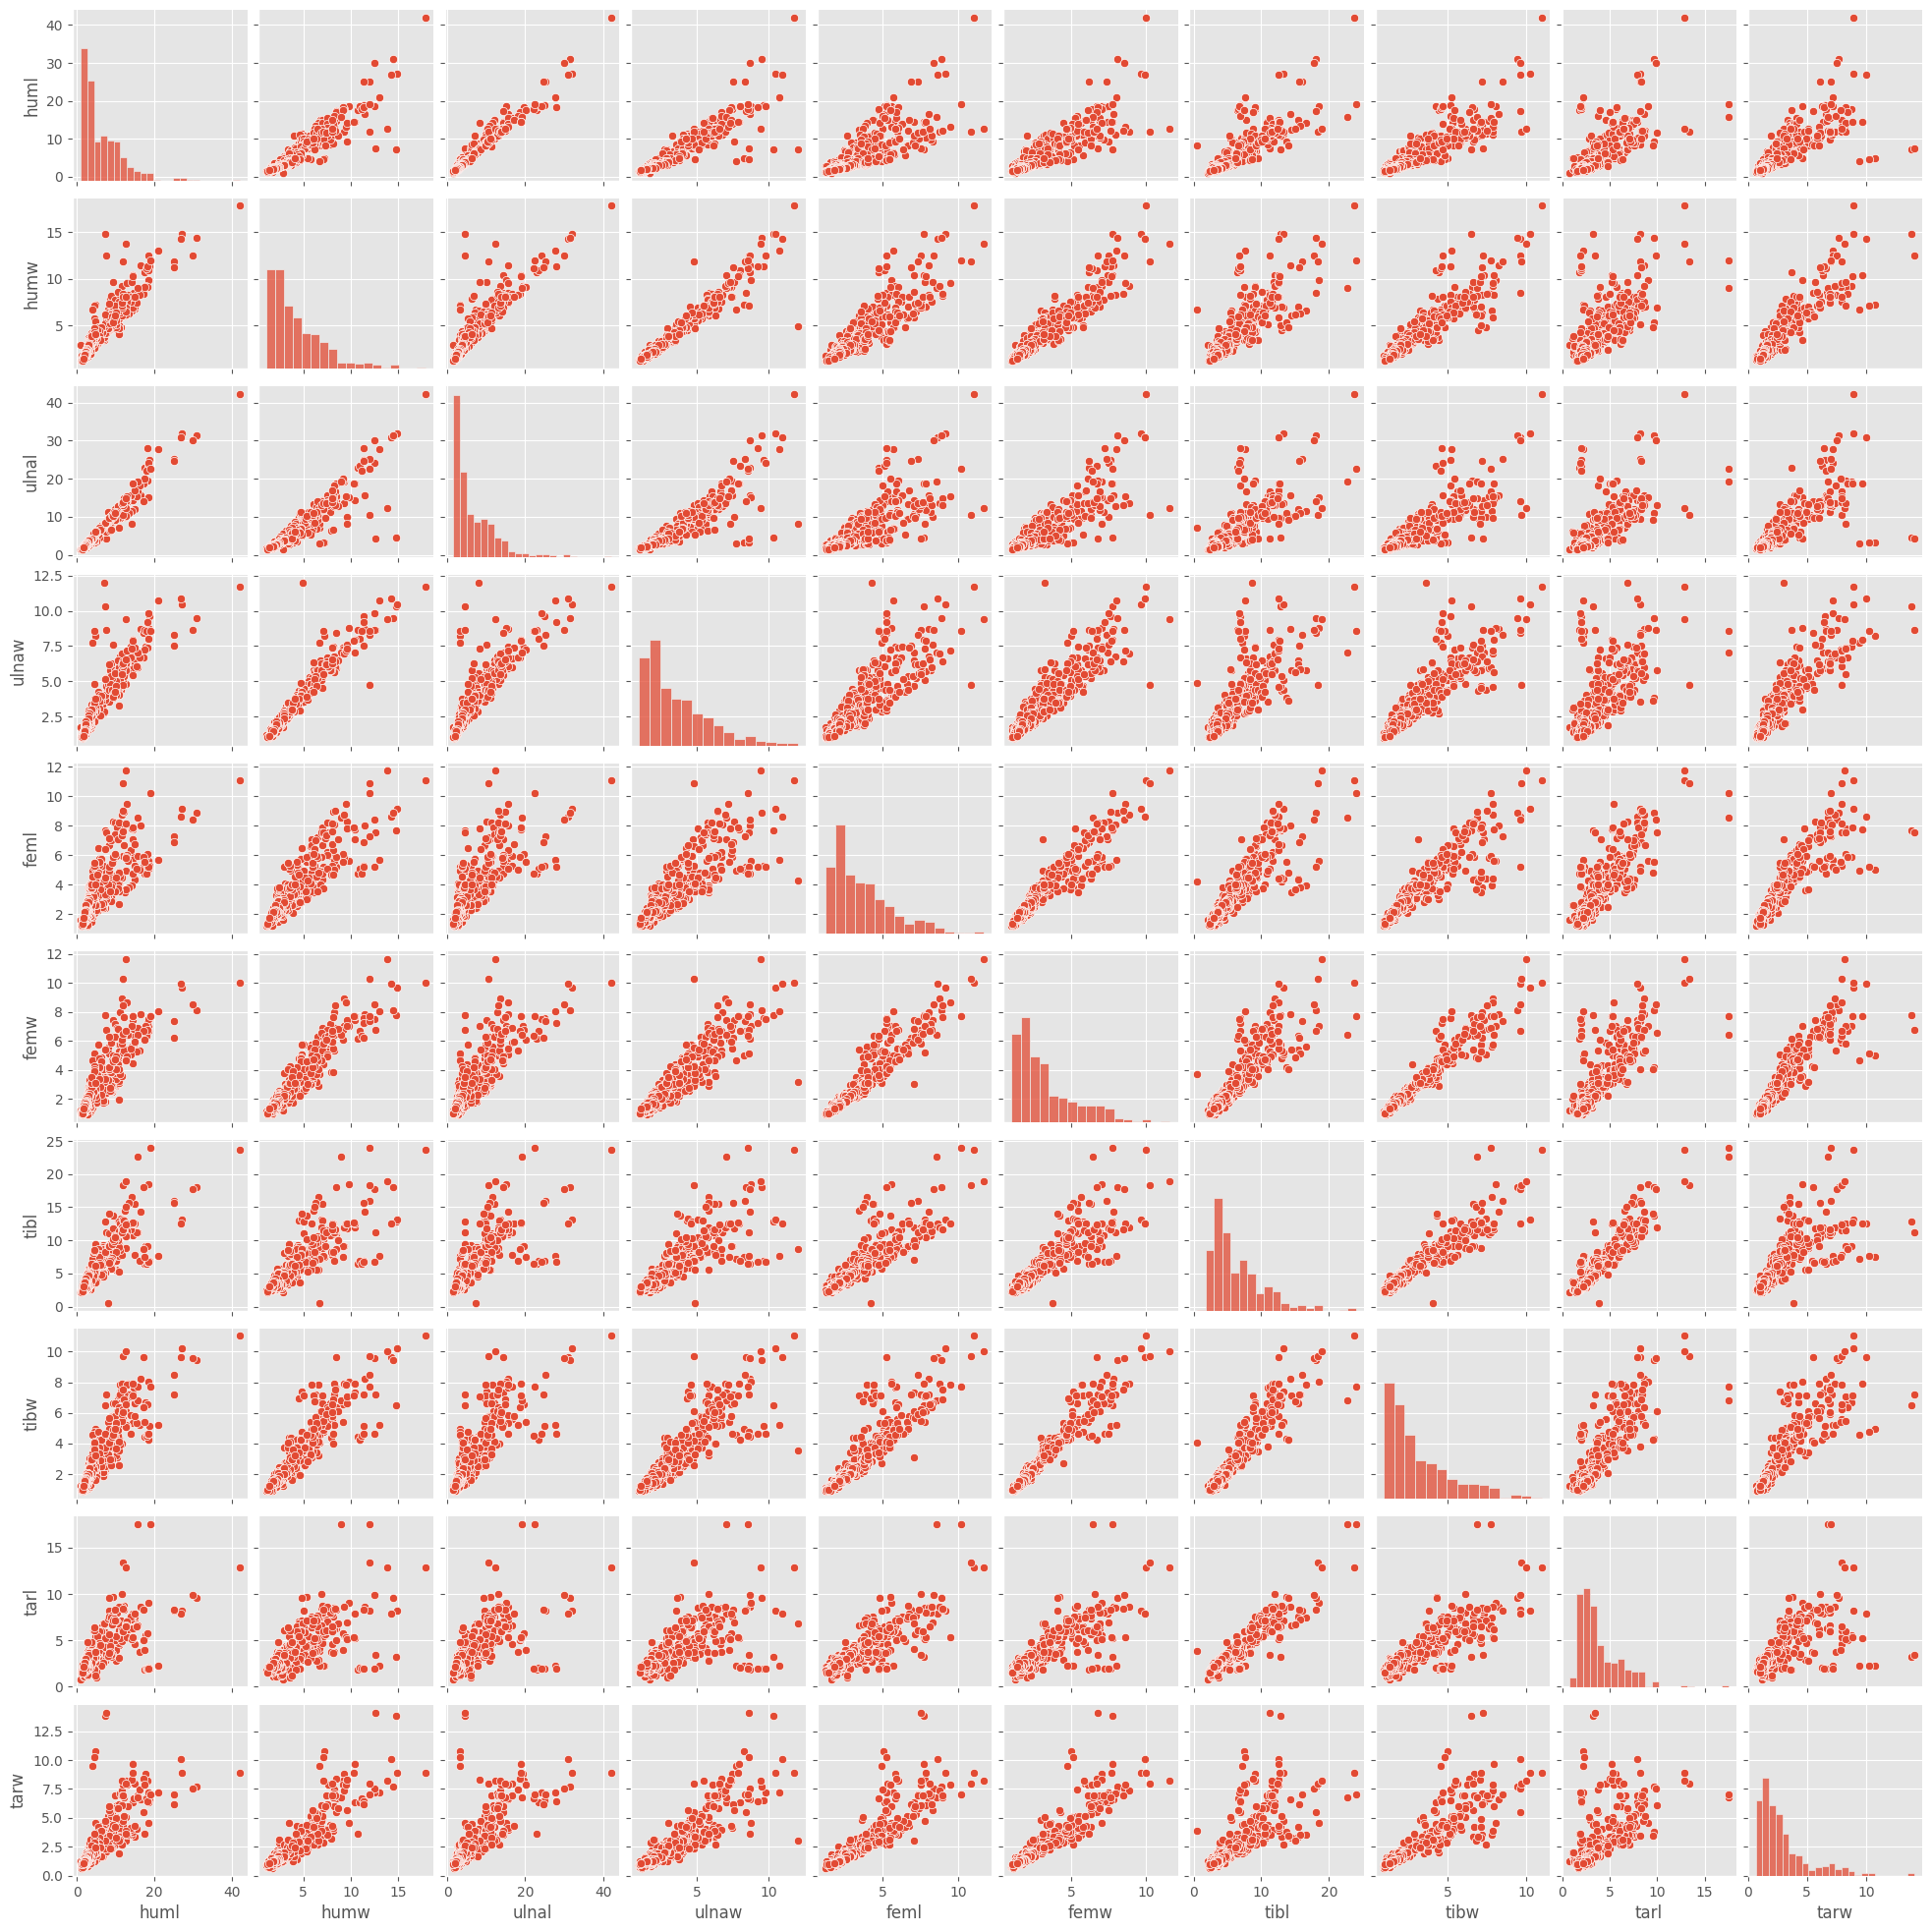

In [ ]:
sns.pairplot(df, height=2)
plt.show()

Ao analisar o scatter plot das variáveis, é possível observar que a maioria delas apresenta uma relação direta, o que faz sentido. Na prática, quando uma ave possui um fêmur de comprimento maior, é provável que também tenha um diâmetro maior para o mesmo fêmur. Da mesma forma, na natureza, há uma tendência de normalização dos tamanhos, de modo que o tamanho do úmero será proporcional ao tamanho da ulna, do fêmur e do tibiotarso, quanto maiores forem essas estruturas. Essa relação também pode ser observada em outras espécies, como os seres humanos, onde é provável que uma pessoa com braços longos também tenha pernas longas ou uma cabeça grande.

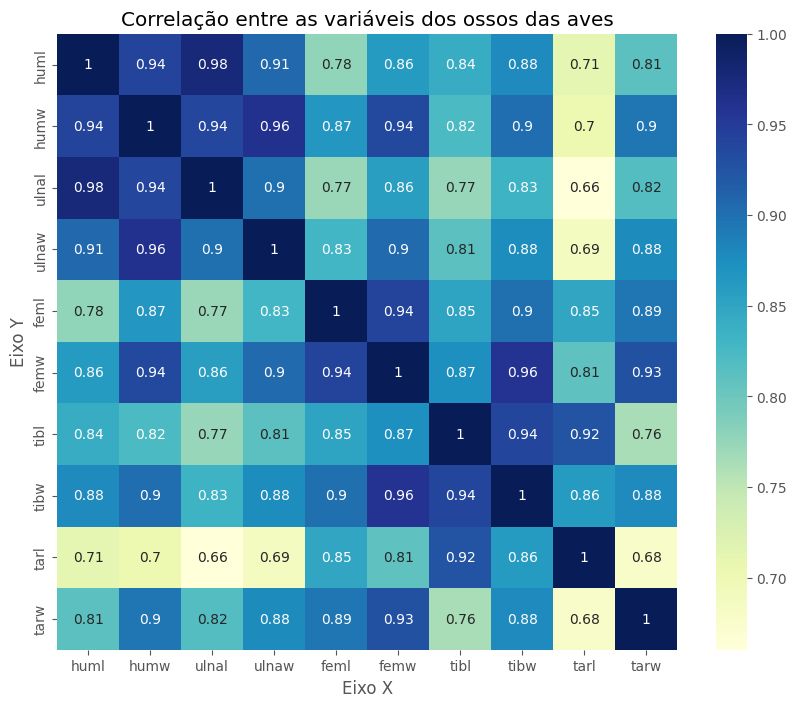

In [ ]:
# Matriz de correlação

correlation_matrix = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))

# Criar o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')

# Configurações adicionais

plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Correlação entre as variáveis dos ossos das aves')

# Exibir o gráfico
plt.show()

Uma forma alternativa de visualizar as relações entre as variáveis é por meio do gráfico de correlação. Nesse gráfico, são exibidas as associações entre as variáveis, onde todas as correlações são superiores a 0,65, com a maioria delas apresentando correlações elevadas em torno de 0,8. Além disso, ao analisar as correlações, podemos observar que o comprimento do Tarsometatarso apresenta uma menor associação com o diâmetro e comprimento de outros ossos das aves. Isso sugere que essa variável pode ter menos influência ou relação direta com as demais características avaliadas.

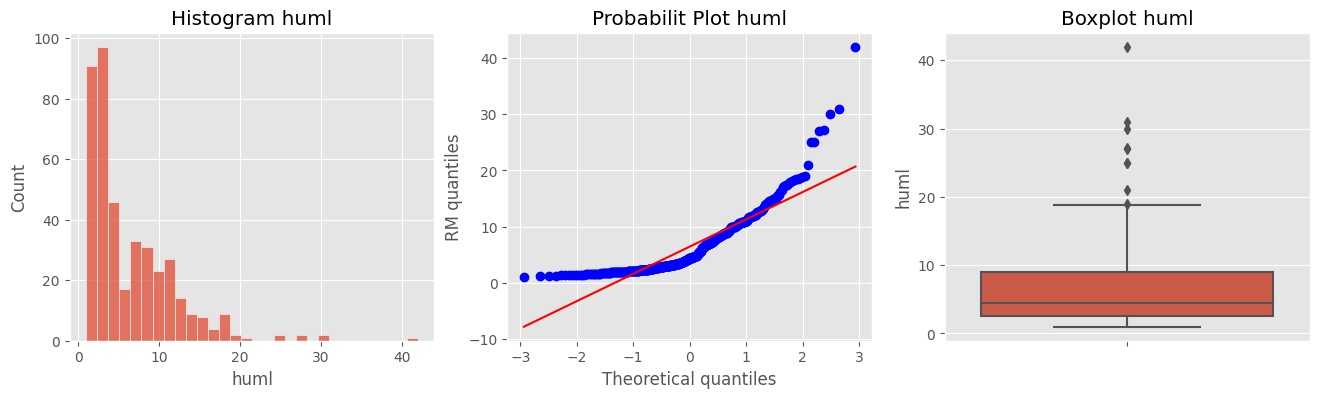

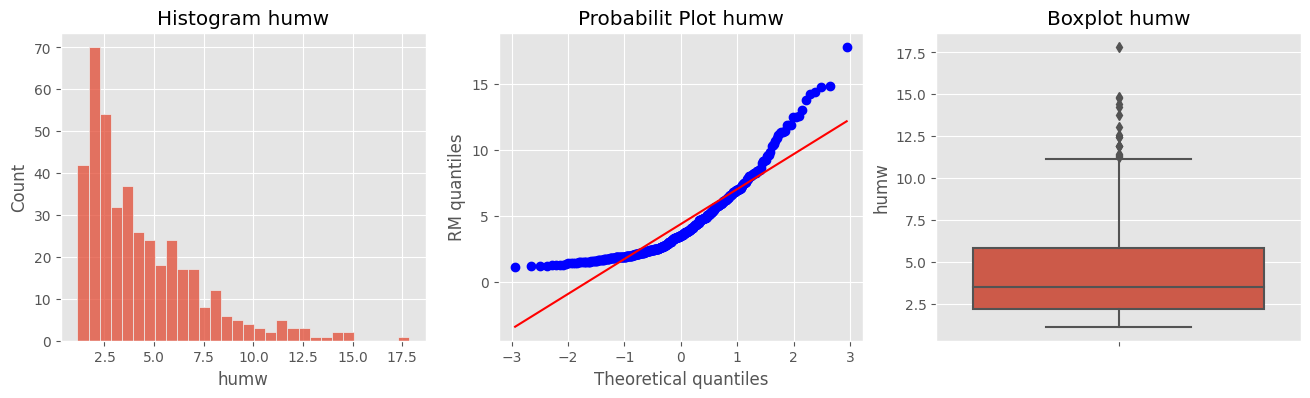

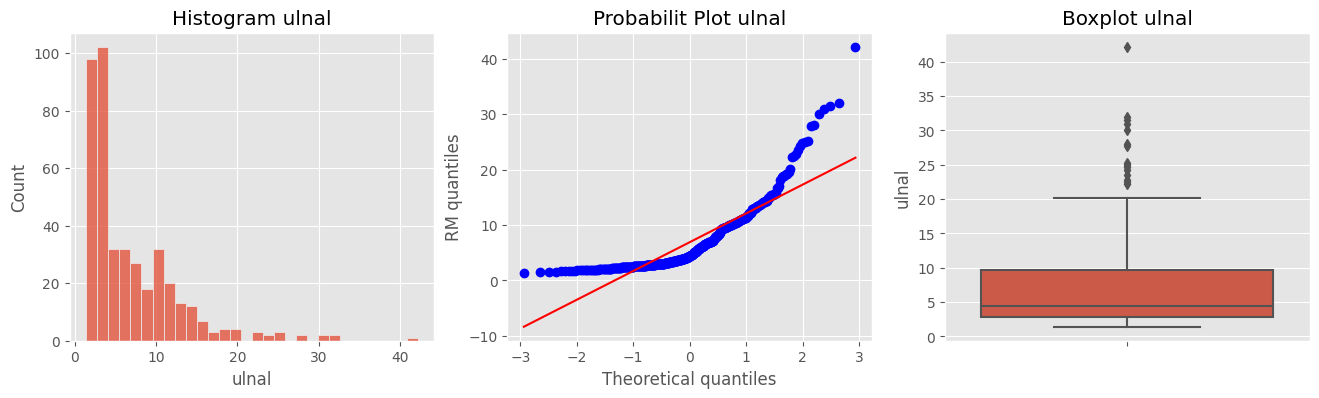

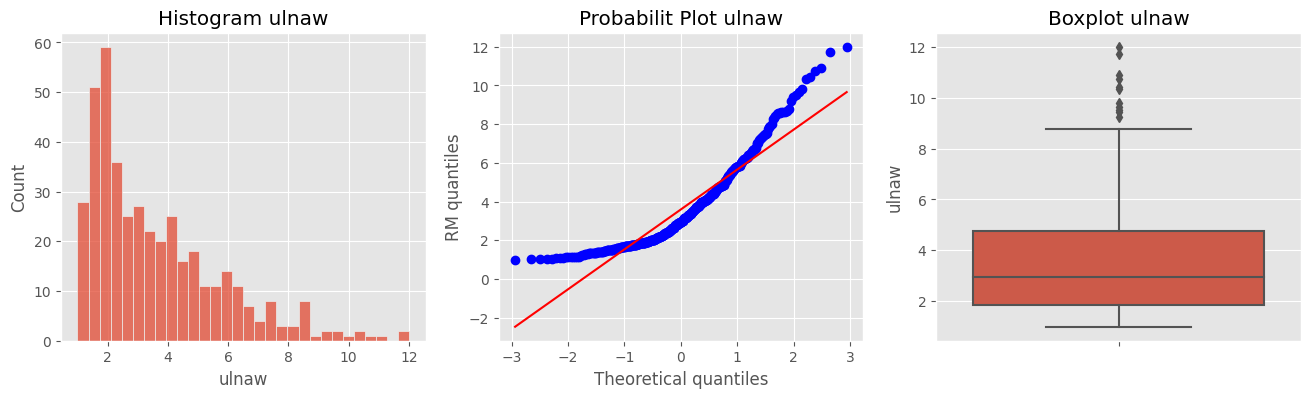

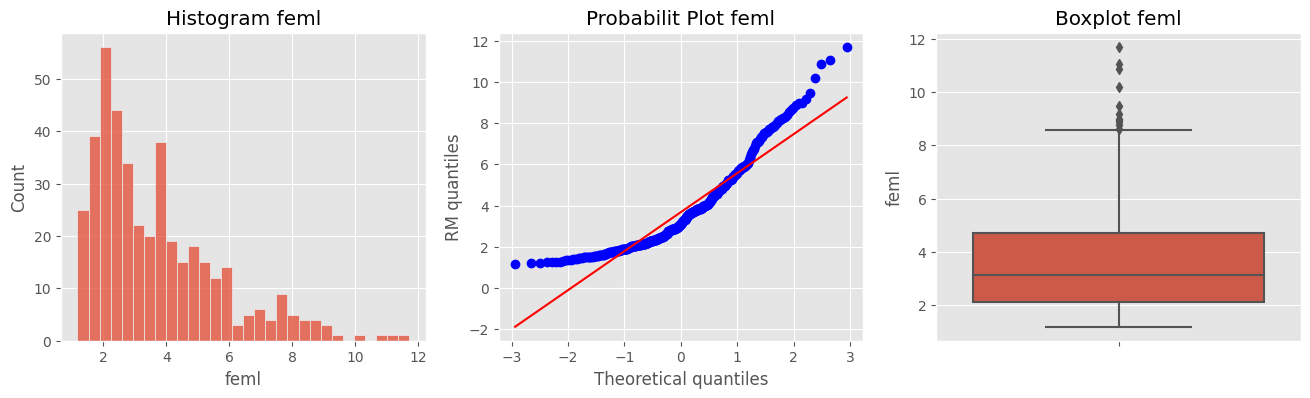

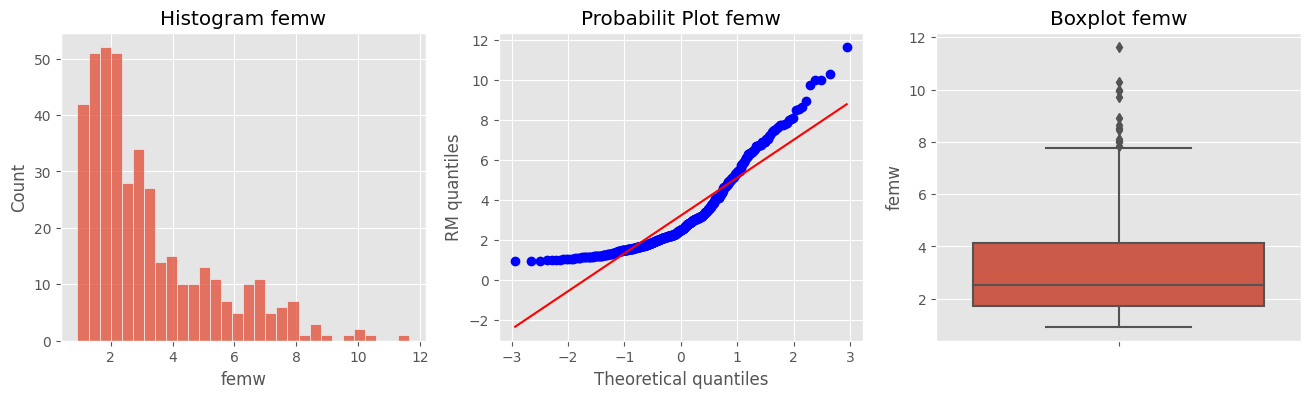

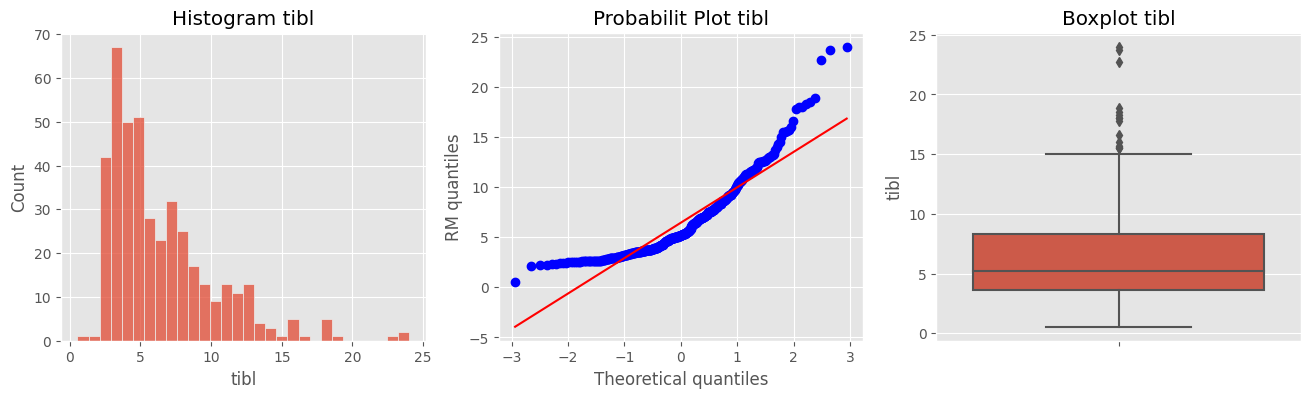

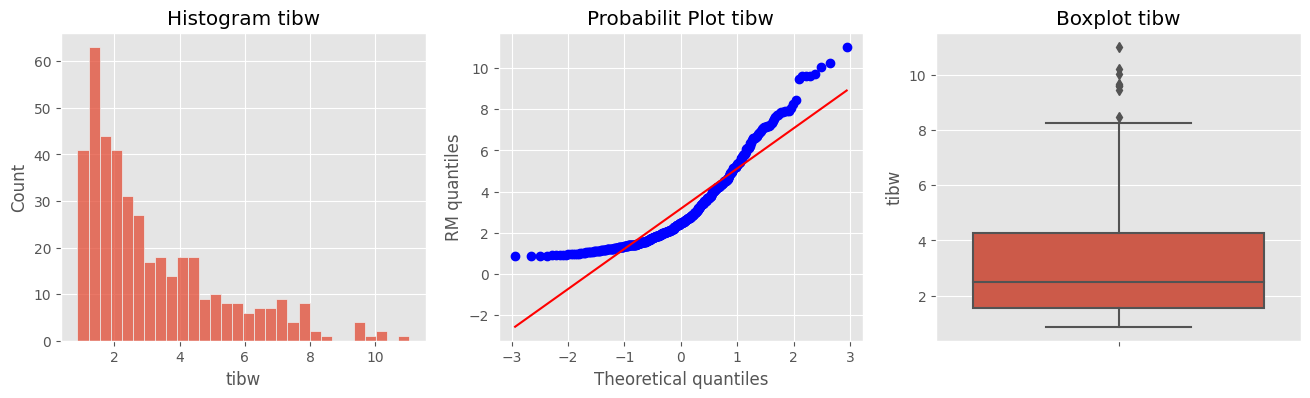

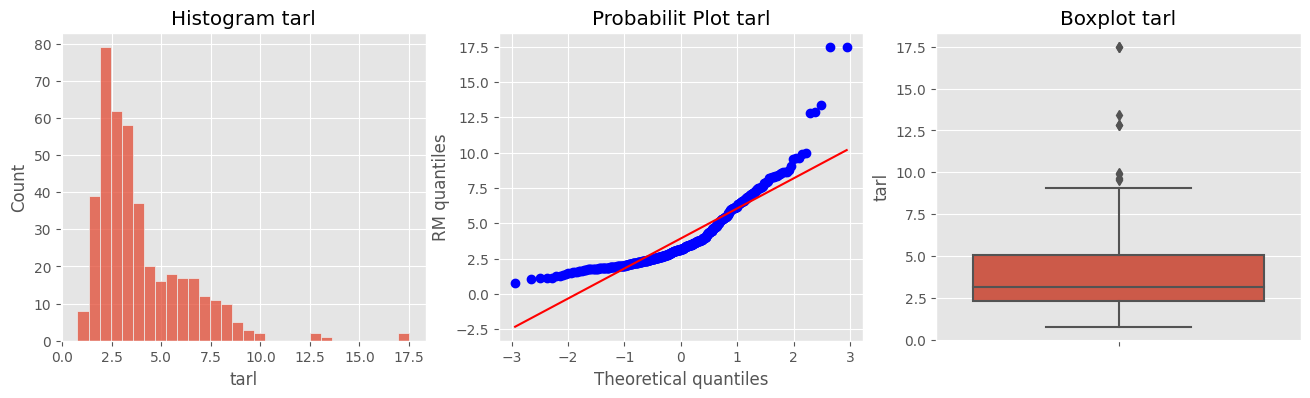

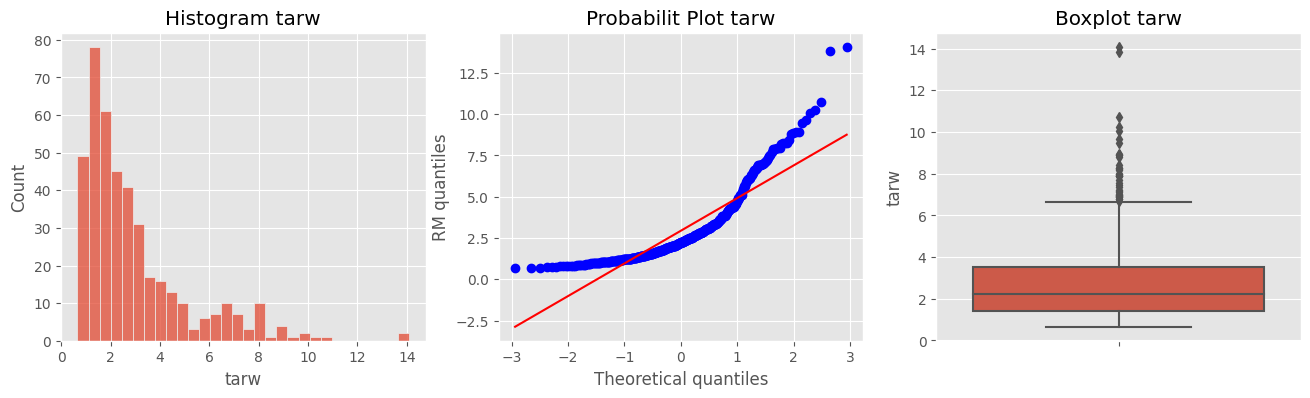

In [ ]:
# categorical
categorical = [var for var in df.columns if df[var].dtype == 'O' ]
for i in df.columns:
  if i not in categorical:
    diagnostic_plots(df, i)

Assim como ocorre para a conclusão a partir do resumo estatístico anteriormente calculado, observa-se pelos histogramas uma maior quantidade de aves de pequeno porte, com medidas de comprimento e de largura menores. Complementando, a distribuição dos gráficos são assimétricas para cada comprimento e diâmetro de cada osso, sendo sempre deslocada para valores mais baixos.


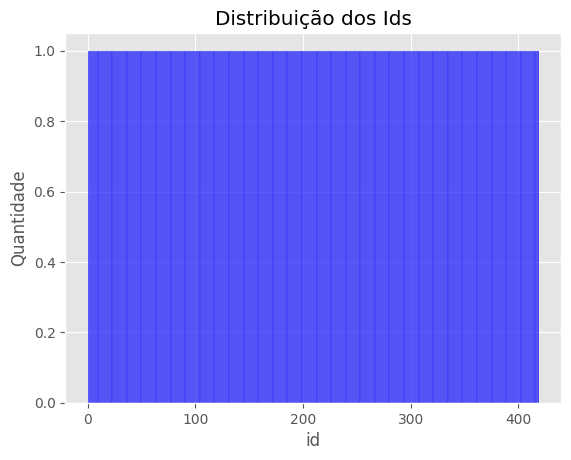

In [ ]:
sns.histplot(id, bins=len(id), color='blue')
plt.title('Distribuição dos Ids')
plt.xlabel("id")
plt.ylabel("Quantidade")
plt.show()

Como é possível ver, ao realizar a distribuição dos ids, observa-se que a relação é de 1 para 1, ou seja, é uma distribuição uniforme, pois há uma quantidade fixa para cada ave.

<a name='out'></a>
##Lidando com outliers

Para minimizar o impacto de *outliers*, opta-se por utilizar o **método dos quantis**, em que se define até que percentil dos dados serão mantidos.

In [ ]:
#Função que retorna os limites com base nos quantis escolhidos
def find_limits(df, variable, q1, q2):
    lower_limit = df[variable].quantile(q1/100)
    upper_limit = df[variable].quantile(q2/100)
    return lower_limit, upper_limit

Pelos gráficos construídos, nota-se que os dados das colunas *tarw* e *tarl* são os casos de maior discrepância. Logo, exclui-se os dados fora do percentil 99,5, removendo apenas os extremos.

In [ ]:
df.shape

(419, 10)

In [ ]:
# Obtendo a forma (shape) do DataFrame antes do corte dos outliers
antes = df.shape

# Definindo e aplicando os limites para corte dos outliers
for i in ['tarw', 'tarl']:
    lower_limit, upper_limit = find_limits(df, i, 0, 99.5)
    df = df[(df[i] <= upper_limit) & (df[i] >= lower_limit)]

# Calculando a diferença de valores removidos
diferenca = antes[0] - df.shape[0]

# Exibindo a quantidade de valores cortados
print('Foram cortados ' + str(diferenca) + ' valores')

Foram cortados 6 valores


<a name='cat'></a>
##Categorical encoding

Não será necessário, visto que todas as colunas são numéricas.

<a name='scal'></a>
## Escalas nas variáveis

Visto que esse problema não possui uma complexidade grande na escolha dos algoritmos, visando o KNN, utiliza-se o **min-max-scailing** com objetivo de normalizar os dados.

In [ ]:
# Definindo o scaler MinMaxScaler e configurando a saída como "pandas"
scaler = MinMaxScaler().set_output(transform="pandas")

# Ajustando o scaler aos dados de treinamento, ele aprenderá os parâmetros
scaler.fit(df)

# Aplicando a transformação aos conjuntos de treinamento e teste
df_scaled = scaler.transform(df)
df_scaled

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
0,0.172937,0.331737,0.141992,0.352727,0.284873,0.258637,0.000000,0.311024,0.256192,0.331942
1,0.192759,0.328743,0.162879,0.417273,0.334569,0.314659,0.322765,0.358268,0.279384,0.349687
2,0.170962,0.313174,0.135250,0.389091,0.296845,0.277311,0.301728,0.312008,0.252961,0.279749
3,0.165305,0.273054,0.126670,0.342727,0.268054,0.241830,0.275032,0.249016,0.232005,0.287056
4,0.129099,0.221557,0.093158,0.248182,0.210186,0.167134,0.219309,0.205709,0.199702,0.257829
...,...,...,...,...,...,...,...,...,...,...
415,0.019773,0.029341,0.012650,0.030000,0.062049,0.056956,0.111231,0.045276,0.117783,0.051148
416,0.022821,0.029940,0.016352,0.044545,0.070410,0.048553,0.119698,0.040354,0.131119,0.051148
417,0.021797,0.029341,0.014072,0.048182,0.086754,0.046685,0.125054,0.053150,0.124990,0.057411
418,0.025674,0.038323,0.020691,0.045455,0.090460,0.051354,0.132138,0.064961,0.150832,0.060543


<a name='transf'></a>
## Transformações de variáveis

Não será necessário para esse problema, dadas as características do modelo **K-Means**.



<a name='disc'></a>
##Discretização de variáveis

Além de não ser necessário, informações seriam perdidas. Visto que o *dataset* não é grande, não há problemas com a capacidade computacional.

<a name='KNN'></a>
#3 - Aplicando o Modelo K-means

<a name='manu'></a>
##Testes 'manuais' e visualização

Dado que o interesse está em valores específicos de K, realiza-se a aplicação do método K-means. Dado que o ***score de Silhouette*** é uma métrica utilizada para avaliar a qualidade dos agrupamentos obtidos por um algoritmo de *clustering*, como o K-means, também se calcula esse valor.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Lista de vizinhos
vizinhos = [2, 3, 4, 5, 6, 9]

# Lista para armazenar os scores de silhouette
scores = []

# Loop para calcular o score de silhouette para diferentes números de clusters
for i in vizinhos:
    # Inicializando o KMeans
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(df_scaled)

    # Obtendo os rótulos dos clusters
    cluster_labels = kmeans.labels_

    # Calculando o score de silhouette
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    scores.append(silhouette_avg)
    print("Para n_clusters={0}, o score de silhouette é {1}".format(i, silhouette_avg))

Para n_clusters=2, o score de silhouette é 0.5954098329137764
Para n_clusters=3, o score de silhouette é 0.5029028216012231
Para n_clusters=4, o score de silhouette é 0.49383460617769714
Para n_clusters=5, o score de silhouette é 0.43467325199523715
Para n_clusters=6, o score de silhouette é 0.3772292628227422
Para n_clusters=9, o score de silhouette é 0.3502453681930728


De posse dos resultados numéricos, procura-se construir a visualização gráficos de tais classificações.

<a name='elbow'></a>
###Elbow curve

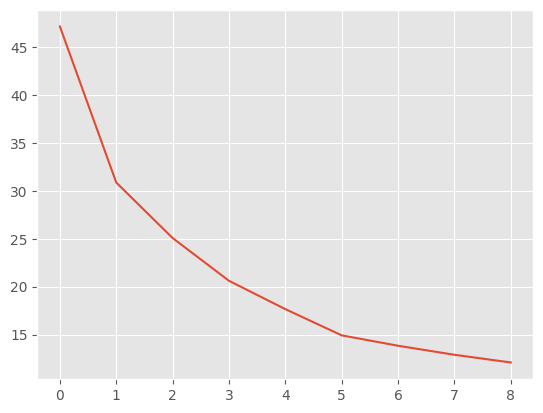

In [ ]:
# Curva de cotovelo / SSD (Soma das distâncias quadráticas)
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop para calcular a SSD para diferentes números de clusters
for num_clusters in range_n_clusters:
    # Inicializando o KMeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)

    # Obtendo a SSD (inertia_)
    ssd.append(kmeans.inertia_)

# Plotando a curva de SSDs para cada número de clusters
plt.plot(ssd)

Para decidir o número ideal de *clusters*, a melhor abordagem seria por meio desse gráfico.

<a name='PCA'></a>
###Plot dos clusters usando PCA

Por fim, diminui-se as dimensões do problema e contrói-se os gráficos para visualizar os clusters, a fim de analisar como as distribuições estão classificadas.

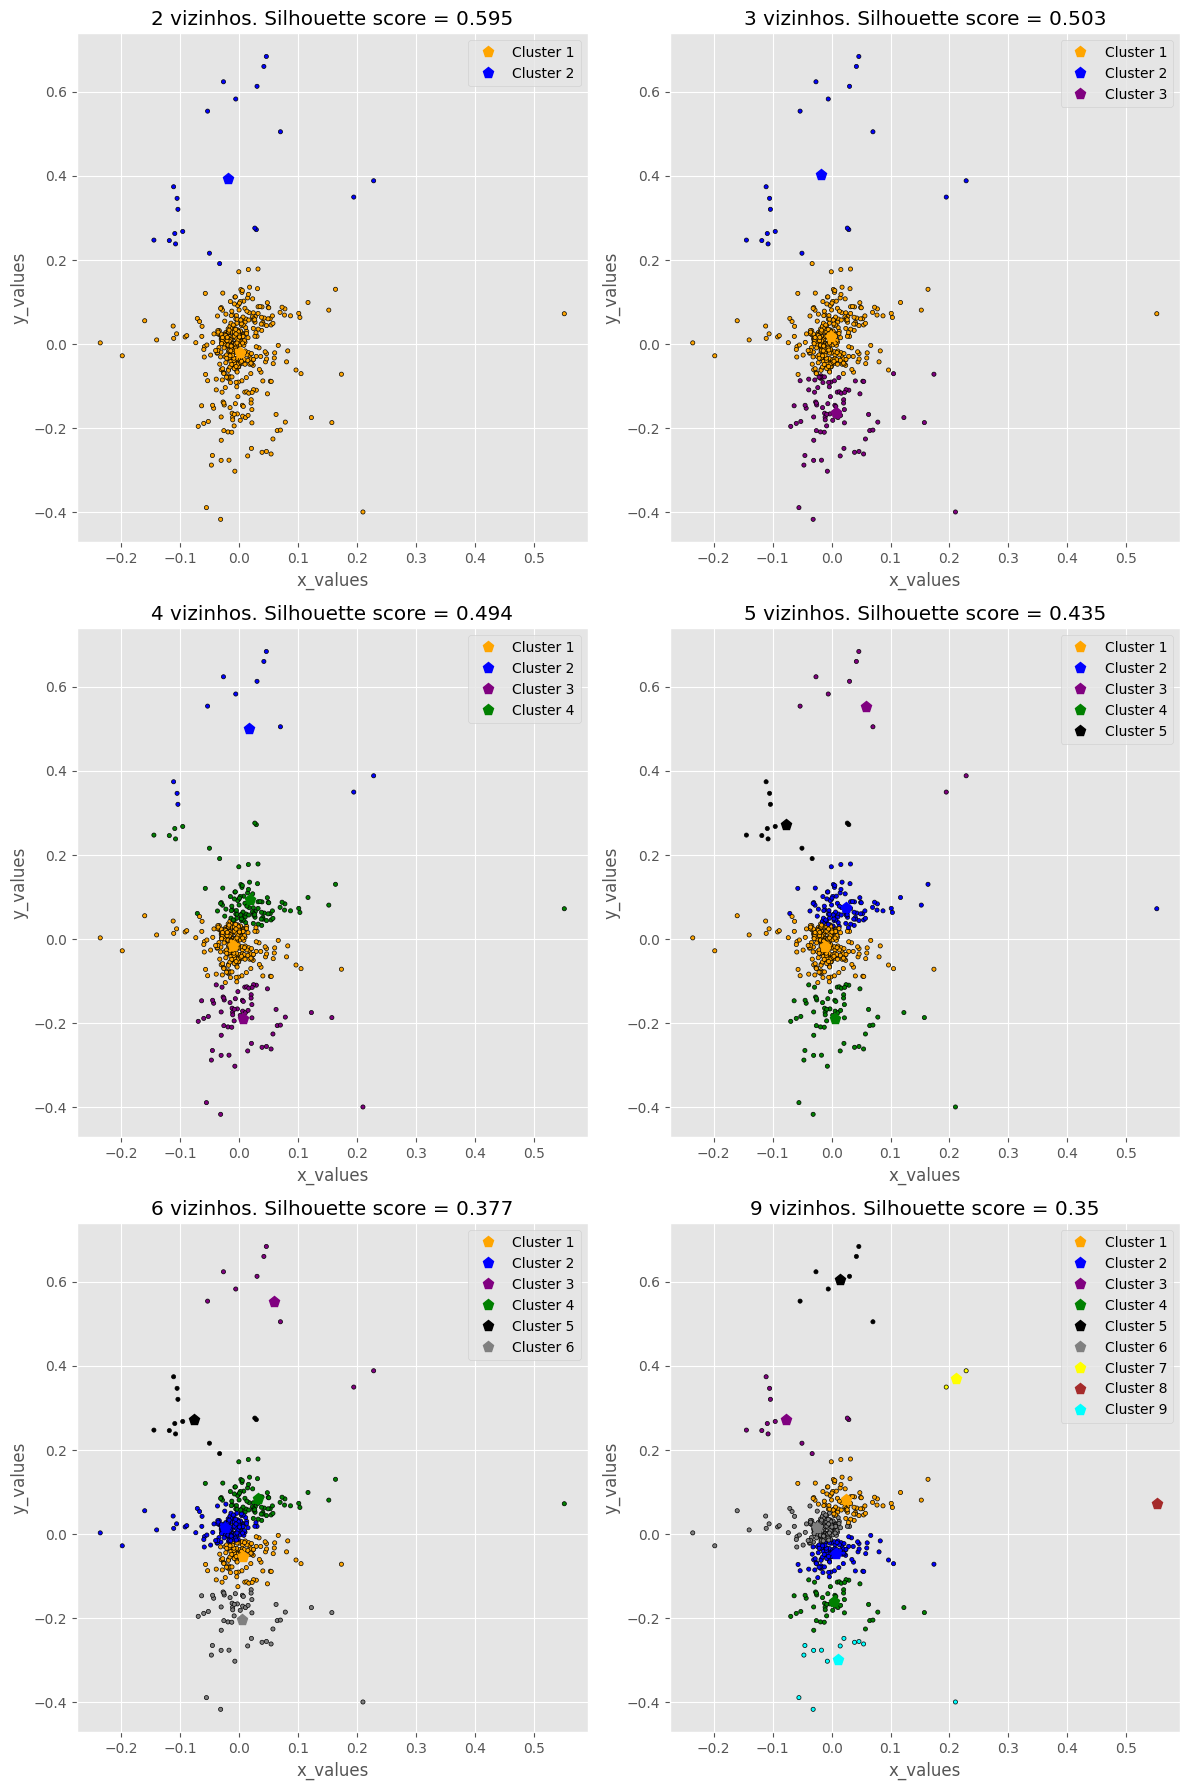

In [ ]:
from sklearn.decomposition import PCA

# Definindo o número de colunas e linhas para o subplot
num_cols = 2
num_rows = round(len(vizinhos) / num_cols)

# Criando a figura e os eixos para o subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Lista de cores para os clusters
colors = ['orange', 'blue', 'purple', 'green', 'black', 'grey', 'yellow', 'brown', 'cyan', 'dark green']

# Loop para plotar os gráficos para diferentes números de vizinhos
for i, n_vizinhos in enumerate(vizinhos):
    # Aplicando a redução de dimensionalidade usando PCA
    pca = PCA(n_components=6)
    pca.fit(df_scaled)
    pca_samples = pca.transform(df_scaled)
    ps = pd.DataFrame(pca_samples)
    tocluster = pd.DataFrame(ps[[4, 1]])

    # Executando o KMeans com o número de clusters definido por n_vizinhos
    clusterer = KMeans(n_clusters=n_vizinhos, random_state=42).fit(tocluster)
    centers = clusterer.cluster_centers_
    c_preds = clusterer.predict(tocluster)

    # Determinando a posição do subplot
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Definindo as cores dos pontos de acordo com os clusters
    colored = [colors[k] for k in c_preds]

    # Plotando os pontos
    ax.scatter(tocluster[4], tocluster[1], marker='.', color=colored, edgecolor='black')

    # Plotando os centroides dos clusters
    for ci, c in enumerate(centers):
        ax.plot(c[0], c[1], 'p', markersize=8, color=colors[ci], alpha=1, label='Cluster ' + str(ci + 1))

    # Configurando os rótulos e título do gráfico
    ax.set_xlabel('x_values')
    ax.set_ylabel('y_values')
    ax.legend()
    ax.set_title(str(n_vizinhos) + ' vizinhos. Silhouette score = ' + str(round(scores[i], 3)))

# Ajustando o layout dos subplots
plt.tight_layout()

# Exibindo os gráficos
plt.show()

<a name='KNN'></a>
#4 - Conclusão

Neste trabalho, foi realizada uma análise exploratória e foram aplicadas técnicas de aprendizado não supervisionado utilizando o método K-Means em um conjunto de dados contendo informações sobre aves. O objetivo principal foi agrupar as aves em *clusters* com base em suas características.

Na etapa de preparação dos dados, foram realizados procedimentos como a exclusão de *features* indesejadas, preenchimento de valores nulos e escalonamento das variáveis. Essas etapas foram essenciais para garantir que os dados estivessem prontos para a aplicação dos métodos de aprendizado não supervisionado.

Na análise exploratória, contruiu-se gráficos *scatter-plot* para as variáveis numéricas do *dataset*, permitindo visualizar as relações entre as características das aves. Também foram analisados histogramas de algumas *features* selecionadas aleatoriamente e da *feature* ID, buscando identificar possíveis distribuições normais ou uniformes. Em seguida, foi aplicado o algoritmo K-Means para realizar a clusterização das aves em 2, 3, 4, 5, 6 e 9 clusters. Foi utilizado o *score de silhouette* como métrica de avaliação da qualidade dos *clusters*.

Observou-se que o *score de silhouette* foi mais alto para 2 *clusters* (0.595), indicando uma melhor separação dos dados nessa configuração. No entanto, também foram observados *scores* razoáveis para 3 e 4 clusters, o que sugere que essas configurações podem ser consideradas, especialmente levando em consideração que problemas da vida real frequentemente requerem mais do que 2 clusters.

Foi realizada ainda uma análise visual dos clusters por meio da redução de dimensionalidade usando PCA. Foram plotados gráficos que mostram a distribuição dos pontos de dados coloridos de acordo com o cluster atribuído, sendo que essa visualização auxiliou na compreensão da separação dos *clusters* e na identificação de possíveis padrões nos dados.

Conclui-se, portanto, que os resultados obtidos foram satisfatórios. Foi possível identificar grupos de aves com características semelhantes com base nas medidas dos ossos do corpo. O método K-Means, com 2 clusters, obteve o melhor resultado em termos de score de silhouette. No entanto, é importante considerar outras configurações de clusters, como 3 e 4, que também apresentaram resultados razoáveis.

Esse trabalho proporcionou uma oportunidade de explorar e aplicar técnicas de análise exploratória e aprendizado não supervisionado em um conjunto de dados real, contribuindo para a consolidação dos conhecimentos em Ciência de Dados.